In [1]:
import sys
sys.path.append('..')

In [2]:
ckpt = '2409/Hagen-indi-l1/16'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'




ckpt = ckpt.strip('/').strip(' ')
ckpt

'2409/Hagen-indi-l1/16'

In [3]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train","distributed"]
    return {k: opt[k]['value'] for k in keys}

In [4]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
print(opt['path']['resume_state'])

/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I1000000_E3125


In [5]:
opt['datasets']['val']['datapath'] = {
 'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
 'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
 }


In [6]:
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I350000_E1094'
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I380000_E1188'
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I360000_E1125'

In [7]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

In [8]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


Computing mean and std for normalization
[SplitDatasetTiledPred] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:0.995 UpperClip:0Uncor:True
[SplitDatasetTiledPred] Tile manager created with grid size 256 and patch size 512


INFO:base:Initialization method [orthogonal]


[SplitDatasetTiledPred] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:0.995 UpperClip:0Uncor:False
[SplitDatasetTiledPred] Tile manager created with grid size 256 and patch size 512
[InDI]: Sampling mode: linear_indi, Noise mode: brownian


INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I1000000_E3125] ...
INFO:base:Model [DDPM] is created.
INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I1000000_E3125] ...


0.030736417 1.0112091 0.02095744 1.0853055 0.014475763 1.6551555


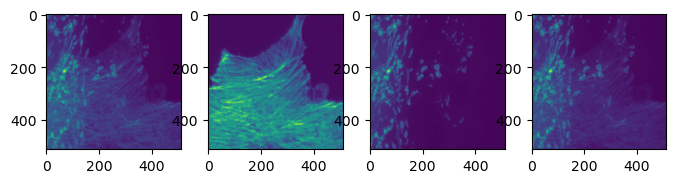

In [9]:
import matplotlib.pyplot as plt

data= train_set[0]
inp = data['input']
target = data['target']
inp = inp.transpose(1,2,0)
target = target.transpose(1,2,0)
inp = (1 + inp) / 2
target = (1 + target) / 2
is_rgb = inp.shape[-1]%3 == 0
nC = 3 if is_rgb else 1
print(inp.min(), inp.max(), target[:nC].min(), target[:nC].max(), target[nC:].min(), target[nC:].max())
_,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].imshow(inp)
ax[1].imshow(target[...,:nC])
ax[2].imshow(target[...,nC:])
ax[3].imshow((target[...,:nC] + target[...,nC:])/2)


In [10]:
import numpy as np
import random

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

norm_dict = val_set.get_normalization_dict()
nimgs = 6
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for data in dloader:
    break

diffusion_data = {'input': data['input'].cuda(), 'target': data['target'].cuda()}
# idx = np.random.randint(0,len(val_set), size=nimgs)
# data = val_set[idx]
# inp = data['input']
# target = data['target']
# diffusion_data = {'input': torch.Tensor(inp)[None].cuda(), 'target': torch.Tensor(target[None]).cuda()}
# inp = inp * norm_dict['std_input'] + norm_dict['mean_input']
# inp = inp/np.max(inp)
# _,ax = plt.subplots(figsize=(2,2))
# plt.imshow(inp.transpose(1,2,0))

In [12]:
def get_prediction(data_dict):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    diffusion.feed_data(data_dict)
    diffusion.test(continous=True, clip_denoised=False)
    visuals = diffusion.get_current_visuals()
    # input, target, prediction = unnormalize_data(visuals,train_set.get_normalization_dict())
    input = visuals['input'].cpu().numpy()
    target = visuals['target'].cpu().numpy()
    prediction = visuals['prediction'].cpu().numpy()

    # unnormalize 
    pred_unnorm = prediction * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
    target_unnorm = target * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [13]:
diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')

target_arr = []
pred_arr = []
input_arr = []
for img_idx in range(nimgs):
    tmp_data = {'input': diffusion_data['input'][img_idx:img_idx+1].cuda(), 'target': diffusion_data['target'][img_idx:img_idx+1].cuda()}
    input_unnorm, target_unnorm, pred_unnorm = get_prediction(tmp_data)
    target_arr.append(target_unnorm)
    pred_arr.append(pred_unnorm[None])
    input_arr.append(input_unnorm)

inputs = np.concatenate(input_arr, axis=0)
targets = np.concatenate(target_arr, axis=0)
predictions = np.concatenate(pred_arr, axis=0)



sampling loop time step: 100%|██████████| 20/20 [00:00<00:00, 47.89it/s]


In [14]:
predictions.shape

(6, 7, 512, 512, 2)

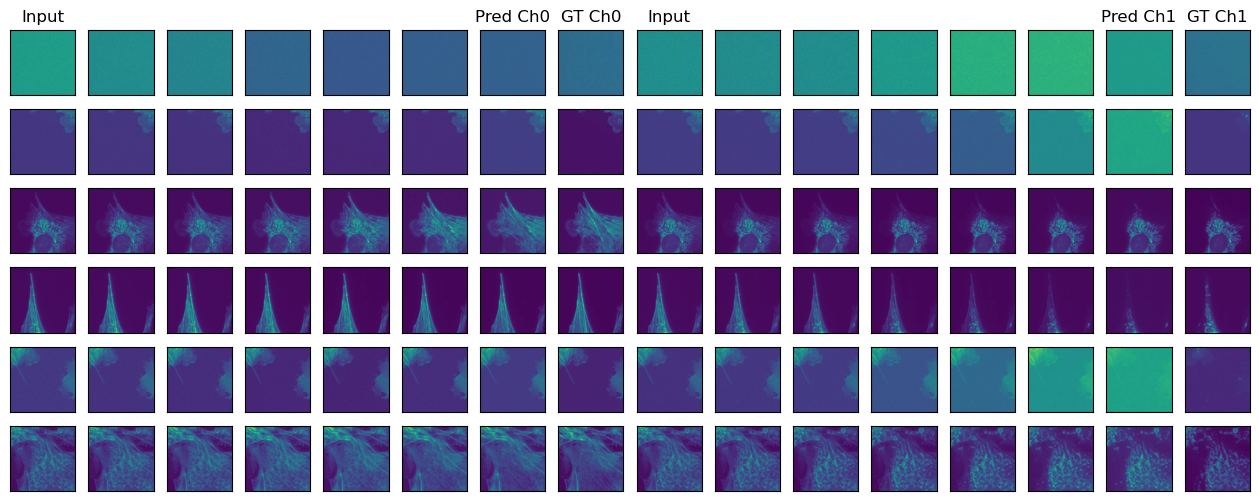

In [15]:
from disentangle.analysis.plot_utils import clean_ax
ncols = predictions.shape[1] + 1
assert nimgs % 2 == 0
nrows = 2*nimgs
dfac = 1
# rgb = target_unnorm.shape[-1]
_,ax = plt.subplots(figsize=(ncols*1*2,nrows*1//2), ncols=ncols*2, nrows=nrows//2)
ax = ax.reshape(nrows,ncols)
for img_idx in range(nimgs):
    for i in range(predictions.shape[1]):
        ax[0+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,:nC])
        ax[1+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,nC:])

    ax[0+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,:nC])
    ax[1+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,nC:])

ax[0,-1].set_title('GT Ch0')
ax[0,0].set_title('Input')
ax[0,-2].set_title('Pred Ch0')

ax[1,-1].set_title('GT Ch1')
ax[1,0].set_title('Input')
ax[1,-2].set_title('Pred Ch1')

clean_ax(ax)

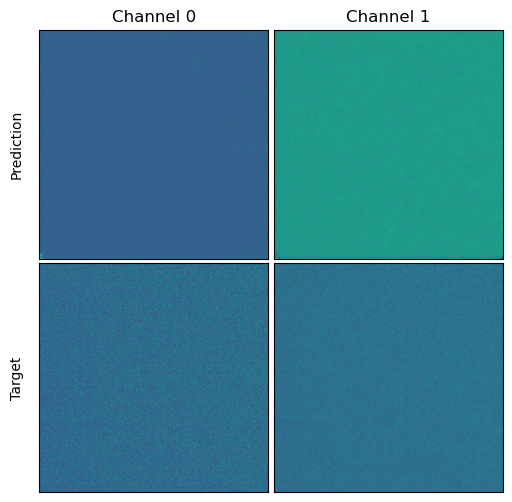

In [16]:
import matplotlib.pyplot as plt 
from disentangle.analysis.plot_utils import clean_ax
img_idx = 0
pred_tmp = predictions[img_idx,-1]
target_tmp = targets[img_idx]

rgb_ch = target_tmp.shape[-1]

_,ax = plt.subplots(figsize=(6,6),ncols=2,nrows=2)
ax[0,0].set_ylabel('Prediction')
ax[1,0].set_ylabel('Target')
ax[0,0].set_title('Channel 0')
ax[0,1].set_title('Channel 1')
ax[0,0].imshow(pred_tmp[...,:rgb_ch//2])
ax[1,0].imshow(target_tmp[...,:rgb_ch//2])

ax[0,1].imshow(pred_tmp[...,rgb_ch//2:])
ax[1,1].imshow(target_tmp[...,rgb_ch//2:])
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

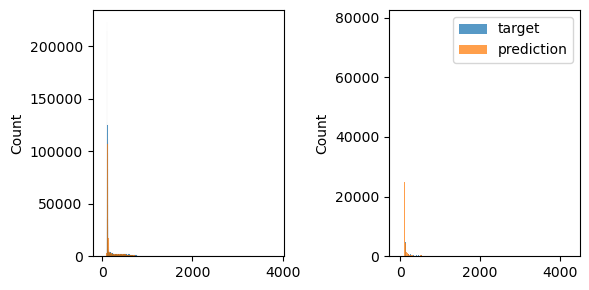

In [17]:
import seaborn as sns
ncols = predictions.shape[-1]
_,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
for ch_idx in range(ncols):
    sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
    sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
plt.legend()
plt.tight_layout()

## Metrics

In [18]:
nC

1

In [19]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm

psnr_dict = defaultdict(list)
predictions = []
targets = []
for i in tqdm(range(len(val_set))):
    data = val_set[i]
    diffusion_data = {'input': torch.Tensor(data['input'])[None].cuda(), 
                      'target': torch.Tensor(data['target'][None]).cuda()
                      }
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(diffusion_data);
    predictions.append(pred_unnorm[-1:])
    targets.append(target_unnorm)
    
    ch0_psnr = torch.mean(PSNR(pred_unnorm[-1,...,:nC].transpose(2,0,1), target_unnorm[0,...,:nC].transpose(2,0,1))).item()
    ch1_psnr = torch.mean(PSNR(pred_unnorm[-1,...,nC:].transpose(2,0,1), target_unnorm[0,...,nC:].transpose(2,0,1))).item()
    psnr_dict['ch0'].append(ch0_psnr)
    psnr_dict['ch1'].append(ch1_psnr)
    

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 490/490 [03:36<00:00,  2.26it/s]


In [20]:
predictions[0].shape

(1, 2, 512, 512)

In [21]:
predictions = np.concatenate(predictions, axis=0)
predictions.shape

(490, 2, 512, 512)

In [22]:
from data.tile_stitcher import stitch_predictions
pred_stitched = stitch_predictions(predictions, val_set.tile_manager)
# target_stitched = stitch_predictions(targets, val_set.tile_manager)

[10, 2048, 2048, 2]


In [43]:
max_val = None
ch0 = np.stack(train_set._data_dict[0])
ch1 = np.stack(train_set._data_dict[1])
target_stitched_train = np.stack([ch0,ch1], axis=-1)
max_val = np.quantile(target_stitched_train,0.995)


In [44]:
ch0 = np.stack(val_set._data_dict[0])
ch1 = np.stack(val_set._data_dict[1])
target_stitched = np.stack([ch0,ch1], axis=-1)
if max_val is not None:
    target_stitched[target_stitched>max_val] = max_val
    pred_stitched[pred_stitched>max_val] = max_val
target_stitched.shape

(10, 2048, 2048, 2)

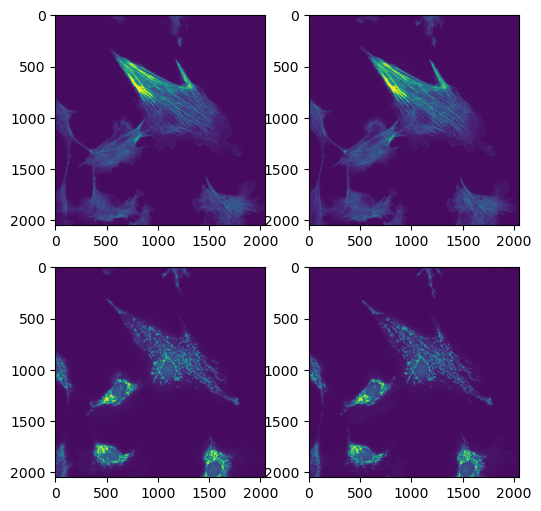

In [45]:
_,ax = plt.subplots(figsize=(6,6),ncols=2,nrows=2)
img_idx = 0
ax[0,0].imshow(pred_stitched[img_idx,...,:nC])
ax[0,1].imshow(target_stitched[img_idx,...,:nC])
ax[1,0].imshow(pred_stitched[img_idx,...,nC:])
ax[1,1].imshow(target_stitched[img_idx,...,nC:])


In [46]:
from core.psnr import RangeInvariantPsnr
ch0psnr, ch1psnr = [RangeInvariantPsnr(target_stitched[...,i]*1.0, pred_stitched[...,i]) for i in range(2)]
print(ch0psnr.mean().item(),ch1psnr.mean().item())


31.589574813842773 31.959035873413086
